# my_database_script_EONERC
Here I will create some basic plots for the data of EONERC. The idea of this notebook is to get an first overview of the data, which comes directly from the DTS device, without processesing.


## I should exclude some functions because they are also used in the other mydatabse script

In [35]:
#######Input###############
# change it to r".\\" if you are executing this notebook directly in the my_database folder
path_to_my_database = r"C:\Users\Mathis\ownCloud\my_EONERC_data" #r".\\" #<-------change-it----------------------
import_type = "pickle" # "csv" "pickle"

# At the moment these inputs are rather only for me
# if you want to use them (True) you may have to adapt some paths in the code
plot_save = True    # True False
# some checks of the data, e.g. nan values
#check = False # True False
############################

In [36]:
# Load packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from collections import defaultdict
import glob
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
from matplotlib import colors
from datetime import date, timedelta

%load_ext autoreload
%autoreload 2

# import functions for importing data
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv
# import functions for measurements per day calculations
from my_func_mvw.functions_measurements_per_day import all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday
# various other functions
from my_func_mvw.functions import get_abspath, read_pickle

print("Some Version information of the imported packages")
# from Phillip Stoffels script: Update Pandas if necessary. Pickle has compatibility problem with pandas 0.23.4: get update if error occurs. \ conda powershell prompt: pip install --upgrade pandas
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version

# Output from Mathis:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Some Version information of the imported packages
pandas: 1.3.2
pickle: 4.0
Python 3.8.11


In [38]:
# Load pickle data
if import_type == "pickle":
    # Load Data 2019+
    path_to_my_database_pickle = path_to_my_database

    data_2020=read_pickle(path_to_my_database_pickle + "\\2020_pickle_charon3")
    data_2021=import_my_database_pickle(2021,path_to_my_database + "\\data_from_charon4\\pickle", controller=3195)
    #alternative
    data_2021=read_pickle(path_to_my_database_pickle + "\\data_all_charon4")

In [39]:
# # Merge the different years (2019+) dics into one
def merge_data_year(list_data_years):
    """input the different year dics as a list"""
    data = {}

    for data_20xx in list_data_years:
        for channel in data_20xx.keys():

            if channel in data.keys():
                data[channel] = pd.concat([data[channel], data_20xx[channel]], axis = 0)

            else: # channel not in data dic
                data[channel] = data_20xx[channel]

    #maybe do sort index; the seperate years are already sorted by index during saving
    return data

data_all = merge_data_year([data_2020, data_2021])


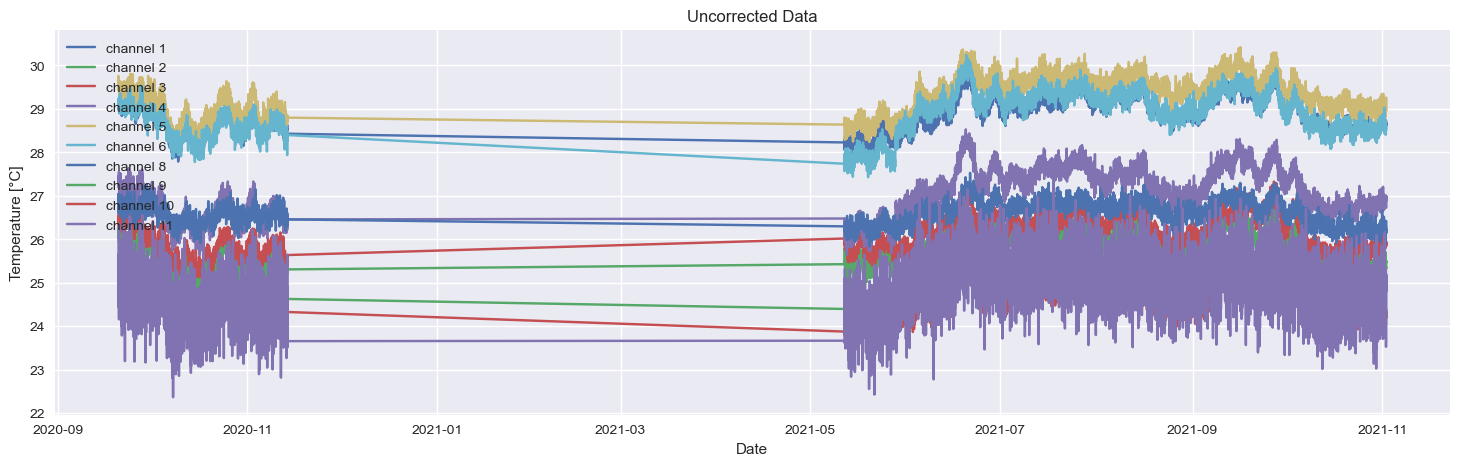

In [40]:
channels=["1","2","3","4","5","6","8","9","10","11"]

# Plot uncorrected data
length=10 # you can change it

plt.figure(figsize=(18,5))
for c in channels:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.title("Uncorrected Data")
plt.legend(loc="upper left") # with large amount of data loc="best" can be slow
plt.show()

# Measurements per day calculation
To-Do - alles nicht so wichtig
* Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt
    * evntl markante Datenpunkte mithilfe von (rotem) Punkt markieren und label / patch dran machen

In [41]:
#count the number of measurements per day; at the moment missing days are not printed

# print("data 2019")
# n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
n_meas_pday_2021 = calculate_measurements_per_day(data_2021, channels=channels)



data 2020


data 2021


In [42]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in the new dictionaries

# n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020, channels=channels)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021, channels=channels)

In [43]:
# Calculate mean measurements per day per channel
#################################UPDATED THIS FUNCTION!!!!!!!!!!!!!!!!!!
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0, channels=channels):
    """calculate the number of measurements as mean over the 4 channels"""
    val={}
    date={}
    for channel in channels:
        val[channel]=np.array(list(n_meas_pday_20xx_with0[channel].values()))
        date[channel]=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))

    #mean measurements per day
    summe=val[channels[0]]
    for channel in channels[1:]:
        summe=summe + val[channel]
    mean=summe/len(channels)

    # # check if dates are equal
    # counter_equal=0
    # counter_not_equal=0
    # for i in range(len(date["1"])):
    #     if date["1"][i] == date["2"][i] and date["3"][i] and date["4"][i] and date["5"][i] and date["6"][i] and date["7"][i] and date["8"][i]:
    #         #print("all dates for mean calculation are equal")
    #         counter_equal+=1
    # else:
    #     #print("dates for mean calculation are not equal!")
    #     #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
    #     counter_not_equal+=1
    # if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
    #     print("check dates")

    #all dates are equal, so I can just return one date
    return mean, date["1"]

# mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

# Plot Measurements per day

In [44]:
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database"""
    save_path = "pictures/" + filename_save + ".png"
    plt.savefig(save_path)
    # copy pictures to my_database
    save_to = r".\test_EONERC"
    copy_file(save_path, save_to)

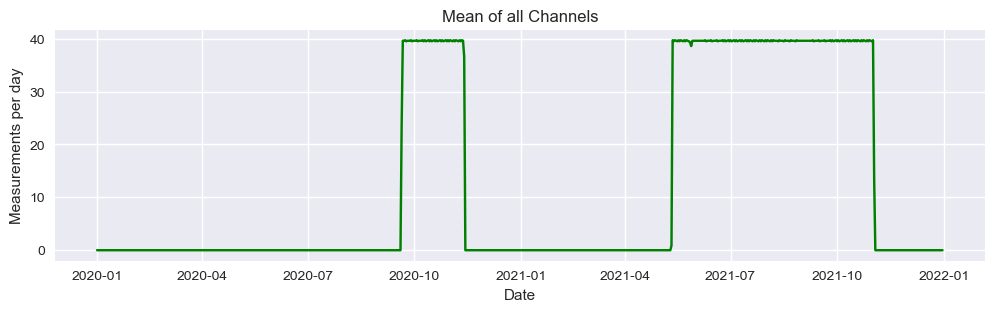

In [45]:
#Plot mean measurements per channel
plt.style.use("seaborn")

plt.figure(figsize=[12,3])
# plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of all Channels")

# # PLOT ACCESSOIREs, Plot Patches with description
# ## some generel settings
# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
# size=11; y=25; ha="center"; va="center"
# x=mdates.date2num(pd.to_datetime("01.01.2020"))
# plt.text(x, y,"data lost due to\noverwriting CF-card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# # p is index of last date with 0 data from behind
# p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# # Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
# plt.text(x, y,"future data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# # Add Patch at begin of measurement of EGRT cable (channel 5-8)
# x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
# ymax=max(np.concatenate([mean_2019,mean_2020,mean_2021])) + 5
# plt.vlines(x, ymin=0, ymax=ymax, colors="black",linestyles="-")
# bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
# x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=142)) 
# plt.text(x, y,"begin measurement EGRT cable\n (channels 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)

# Add txt for dates of data gaps

if plot_save:
    plot_save_func("EONERC_mean_of_all_channels_measpday")

plt.show()

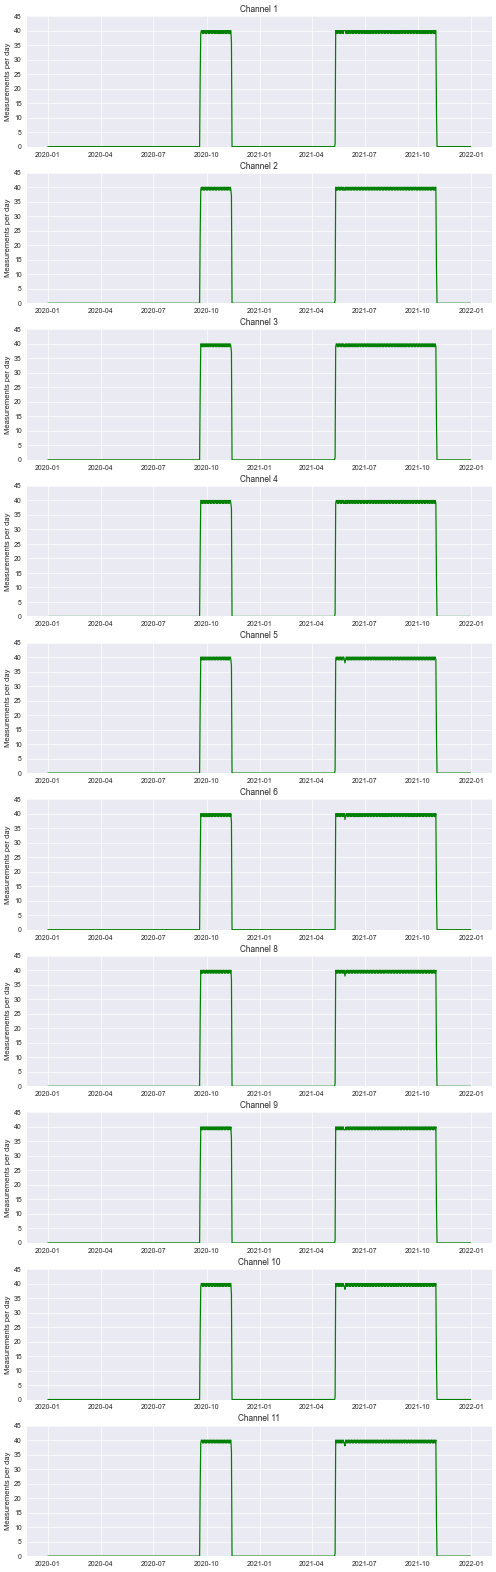

In [46]:
# Plot each channel seperate
#from cycler import cycler

# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(len(channels),1,figsize=[12,4*len(channels)], dpi=50)
counter=0
for channel in channels:
    n=counter
    c="green"
    # axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    #axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
    axs[n].set_ylim([0,45])

    counter+=1
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

# # PLOT ACCESSOIREs, Plot Patches with description - copied from mean plot
# ## some generel settings
# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
# size=11; y=50; ha="center"; va="center"
# x=mdates.date2num(pd.to_datetime("01.01.2020"))
# axs[0].text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# # p is index of last date with 0 data from behind
# p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# # Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=200)))
# axs[0].text(x, y,"future data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box
# x=mdates.date2num(pd.to_datetime("14.07.2021") + timedelta(days=4)) # EGRT Test Channel 5 and 6: 14.07. bis 21.07.
# y=25
# axs[0].text(x, y,"EGRT in\nchannels 5 and 6", ha=ha, va=va, size=size, bbox=bbox_props)
# y=50
# # Add Patch at begin of measurement of EGRT cable (channel 5-8)
# #x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')) #date of first measurement of EGRT Cable
# bbox_props = dict(boxstyle="rarrow", fc="w", ec="0.5", alpha=0.9)
# x=mdates.date2num(pd.to_datetime('2021-06-01 13:26:07')- timedelta(days=142)) 
# axs[0].text(x, y,"begin measurement EGRT cable\n (channels 5 to 8)\n2021-06-01", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plot_save_func("EONERC_all_channels_measpday")
    
plt.show()